# Week 04 — Regularization & Validation

This notebook covers techniques to control overfitting and select models robustly. You'll:
- Understand and implement L1/L2 regularization
- Master cross-validation strategies
- Apply time-series aware validation techniques

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, ElasticNet
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
%matplotlib inline

np.random.seed(42)
print("Libraries imported!")

Libraries imported!


In [ ]:

import os, pickle

CACHE_DIR = "cache_week06"
os.makedirs(CACHE_DIR, exist_ok=True)

def save_result(key, obj):
    with open(os.path.join(CACHE_DIR, f"{key}.pkl"), "wb") as f:
        pickle.dump(obj, f)

def load_result(key):
    path = os.path.join(CACHE_DIR, f"{key}.pkl")
    if os.path.exists(path):
        with open(path, "rb") as f:
            return pickle.load(f)
    return None

def cached(key, compute_fn):
    result = load_result(key)
    if result is not None:
        print(f"[cache] loaded '{key}'")
        return result
    print(f"[cache] computing '{key}'...")
    result = compute_fn()
    save_result(key, result)
    return result

print("Cache utilities ready. Results will be stored in:", CACHE_DIR)


Cache utilities ready. Results will be stored in: cache_week04


## 1. Ridge vs Lasso Regularization

Compare L2 (Ridge) and L1 (Lasso) regularization on synthetic data.

[cache] loaded 'ridge_alpha1.0'
[cache] loaded 'lasso_alpha1.0'


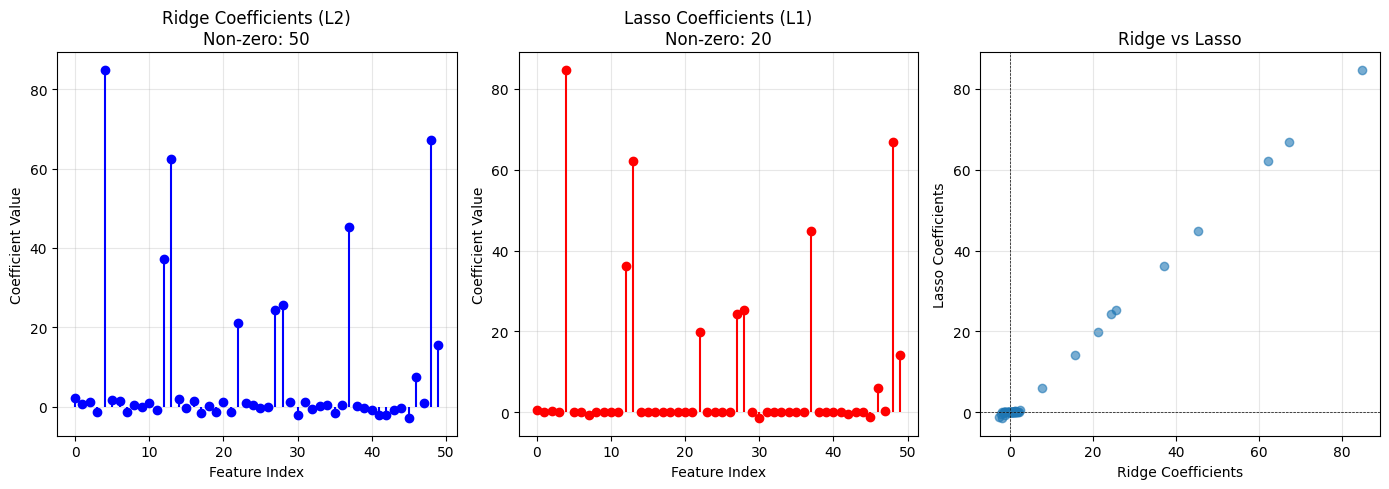

Ridge: 50 non-zero coefficients
Lasso: 20 non-zero coefficients (feature selection!)


In [3]:

n_samples = 100
n_features = 50
X, y = make_regression(n_samples=n_samples, n_features=n_features,
                       n_informative=10, noise=10, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

alpha = 1.0

def _fit_ridge():
    m = Ridge(alpha=alpha); m.fit(X_scaled, y); return m
def _fit_lasso():
    m = Lasso(alpha=alpha); m.fit(X_scaled, y); return m

ridge = cached("ridge_alpha1.0", _fit_ridge)
lasso = cached("lasso_alpha1.0", _fit_lasso)

plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.stem(ridge.coef_, linefmt='b-', markerfmt='bo', basefmt=' ')
plt.title(f'Ridge Coefficients (L2)\nNon-zero: {np.sum(np.abs(ridge.coef_) > 1e-3)}')
plt.xlabel('Feature Index'); plt.ylabel('Coefficient Value'); plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
plt.stem(lasso.coef_, linefmt='r-', markerfmt='ro', basefmt=' ')
plt.title(f'Lasso Coefficients (L1)\nNon-zero: {np.sum(np.abs(lasso.coef_) > 1e-3)}')
plt.xlabel('Feature Index'); plt.ylabel('Coefficient Value'); plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
plt.scatter(ridge.coef_, lasso.coef_, alpha=0.6)
plt.xlabel('Ridge Coefficients'); plt.ylabel('Lasso Coefficients')
plt.title('Ridge vs Lasso'); plt.grid(alpha=0.3)
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.axvline(0, color='k', linestyle='--', linewidth=0.5)
plt.tight_layout(); plt.show()

print(f"Ridge: {np.sum(np.abs(ridge.coef_) > 1e-3)} non-zero coefficients")
print(f"Lasso: {np.sum(np.abs(lasso.coef_) > 1e-3)} non-zero coefficients (feature selection!)")


## 2. Cross-Validation for Hyperparameter Selection

Use k-fold cross-validation to select the regularization strength (alpha).

[cache] loaded 'ridge_lasso_cv_scores_50alphas'
Ridge optimal alpha: 0.2683
Lasso optimal alpha: 0.8286


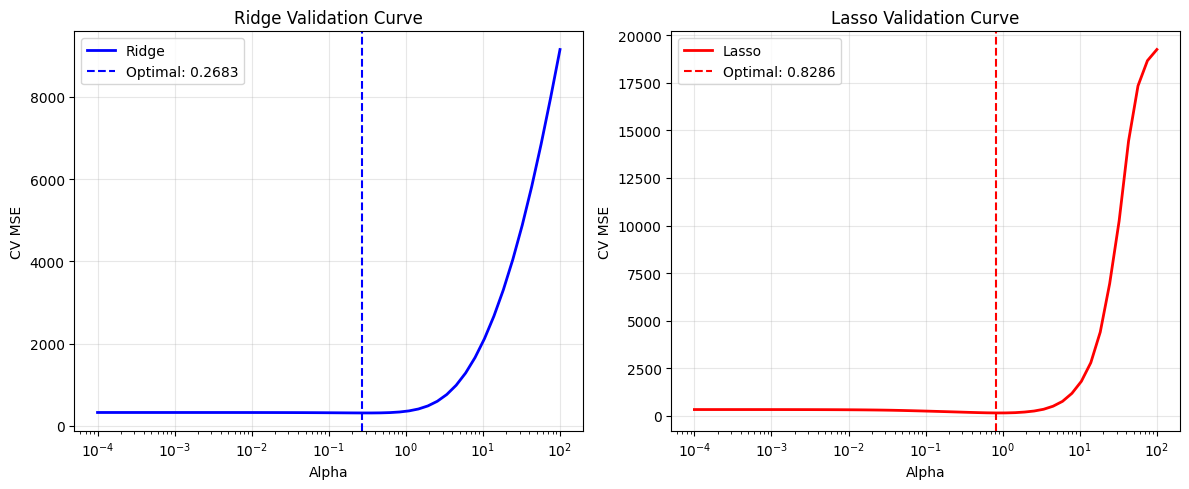

In [4]:

alphas = np.logspace(-4, 2, 50)

def _cv_scores():
    ridge_cv = RidgeCV(alphas=alphas, cv=5)
    lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
    ridge_cv.fit(X_scaled, y)
    lasso_cv.fit(X_scaled, y)

    r_scores = [-cross_val_score(Ridge(alpha=a), X_scaled, y, cv=5,
                  scoring='neg_mean_squared_error').mean() for a in alphas]
    l_scores = [-cross_val_score(Lasso(alpha=a, max_iter=10000), X_scaled, y, cv=5,
                  scoring='neg_mean_squared_error').mean() for a in alphas]
    return ridge_cv.alpha_, lasso_cv.alpha_, r_scores, l_scores

ridge_alpha, lasso_alpha, ridge_scores, lasso_scores = cached(
    "ridge_lasso_cv_scores_50alphas", _cv_scores)

print(f"Ridge optimal alpha: {ridge_alpha:.4f}")
print(f"Lasso optimal alpha: {lasso_alpha:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.semilogx(alphas, ridge_scores, 'b-', linewidth=2, label='Ridge')
plt.axvline(ridge_alpha, color='b', linestyle='--', label=f'Optimal: {ridge_alpha:.4f}')
plt.xlabel('Alpha'); plt.ylabel('CV MSE'); plt.title('Ridge Validation Curve')
plt.legend(); plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogx(alphas, lasso_scores, 'r-', linewidth=2, label='Lasso')
plt.axvline(lasso_alpha, color='r', linestyle='--', label=f'Optimal: {lasso_alpha:.4f}')
plt.xlabel('Alpha'); plt.ylabel('CV MSE'); plt.title('Lasso Validation Curve')
plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()


## 3. Time-Series Cross-Validation

Implement walk-forward validation for time-series data.

[cache] loaded 'timeseries_cv_ridge'
Time Series CV MSE scores: [0.69325667 0.53206047 0.48577086 0.49360022 0.41095975]
Mean CV MSE: 0.5231 +/- 0.0937


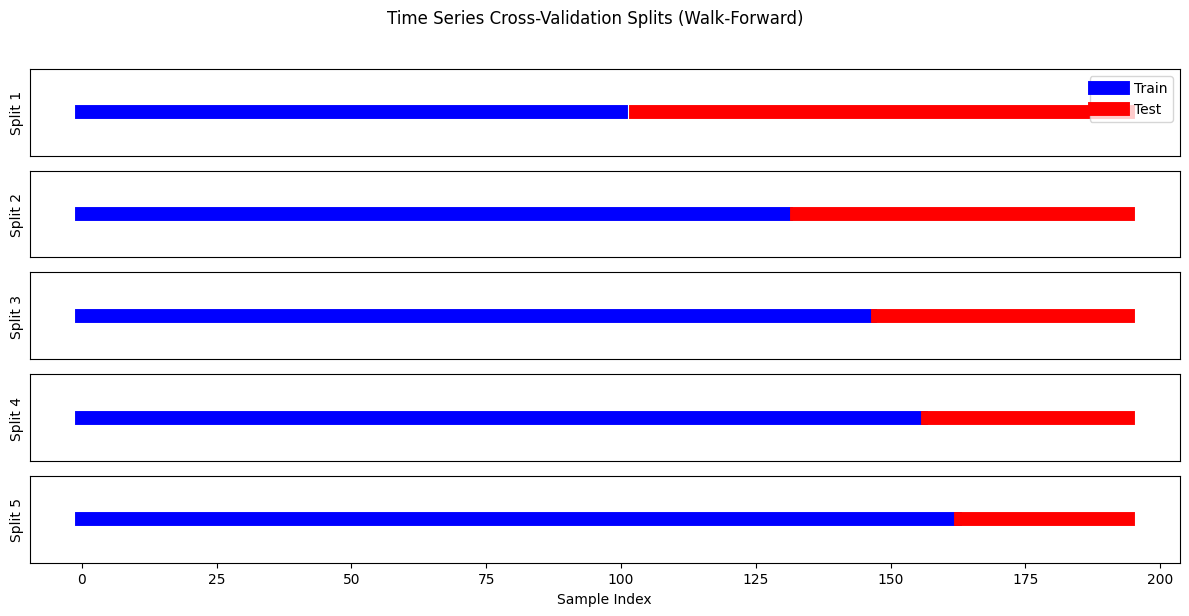

In [5]:

n_samples_ts = 200
time = np.linspace(0, 10, n_samples_ts)
y_ts = 0.5 * time + 2 * np.sin(2 * np.pi * time / 2) + np.random.randn(n_samples_ts) * 0.5

def create_lag_features(y, n_lags=5):
    X = np.zeros((len(y) - n_lags, n_lags))
    for i in range(n_lags):
        X[:, i] = y[n_lags-i-1:len(y)-i-1]
    return X, y[n_lags:]

X_ts, y_ts_target = create_lag_features(y_ts, n_lags=5)

def _timeseries_cv():
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(Ridge(alpha=1.0), X_ts, y_ts_target, cv=tscv,
                             scoring='neg_mean_squared_error')
    return scores

scores = cached("timeseries_cv_ridge", _timeseries_cv)
tscv = TimeSeriesSplit(n_splits=5)

print("Time Series CV MSE scores:", -scores)
print(f"Mean CV MSE: {-scores.mean():.4f} +/- {scores.std():.4f}")

plt.figure(figsize=(12, 6))
for i, (train_idx, test_idx) in enumerate(tscv.split(X_ts)):
    plt.subplot(tscv.n_splits, 1, i+1)
    plt.plot(train_idx, np.ones(len(train_idx)) * i, 'b-', linewidth=10,
             label='Train' if i == 0 else '')
    plt.plot(test_idx,  np.ones(len(test_idx))  * i, 'r-', linewidth=10,
             label='Test'  if i == 0 else '')
    plt.ylabel(f'Split {i+1}'); plt.yticks([])
    if i == 0: plt.legend(loc='upper right')
    if i < tscv.n_splits - 1: plt.xticks([])
plt.xlabel('Sample Index')
plt.suptitle('Time Series Cross-Validation Splits (Walk-Forward)', y=1.02)
plt.tight_layout(); plt.show()


## 4. Elastic Net: Combining L1 and L2

Explore Elastic Net which combines Ridge and Lasso regularization.

[cache] loaded 'elasticnet_l1ratios_0.1_0.5_0.9'


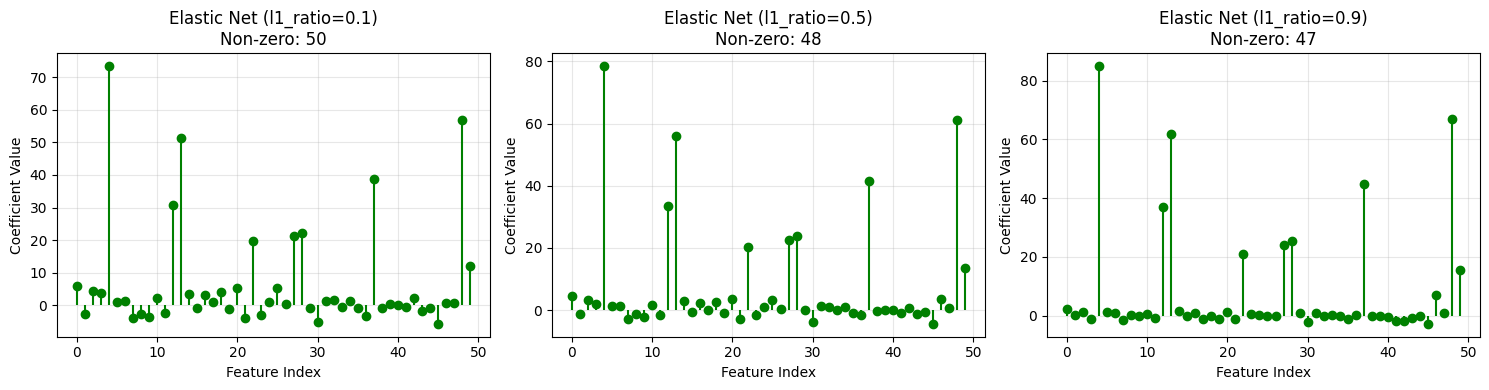

In [6]:

l1_ratios = [0.1, 0.5, 0.9]

def _fit_elastic_nets():
    models = {}
    for l1_ratio in l1_ratios:
        m = ElasticNet(alpha=0.1, l1_ratio=l1_ratio, max_iter=10000)
        m.fit(X_scaled, y)
        models[l1_ratio] = m.coef_.copy()
    return models

elastic_coefs = cached("elasticnet_l1ratios_0.1_0.5_0.9", _fit_elastic_nets)

plt.figure(figsize=(15, 4))
for i, l1_ratio in enumerate(l1_ratios):
    coef = elastic_coefs[l1_ratio]
    plt.subplot(1, 3, i+1)
    plt.stem(coef, linefmt='g-', markerfmt='go', basefmt=' ')
    plt.title(f'Elastic Net (l1_ratio={l1_ratio})\nNon-zero: {np.sum(np.abs(coef) > 1e-3)}')
    plt.xlabel('Feature Index'); plt.ylabel('Coefficient Value'); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()


## Exercises for Further Practice

1. **Implement Coordinate Descent**: Code Lasso using coordinate descent algorithm
2. **Regularization Path**: Plot the full regularization path showing how coefficients change with alpha
3. **Early Stopping**: Implement early stopping as a form of regularization
4. **Dropout Simulation**: Simulate dropout on linear models
5. **Real Financial Data**: Apply time-series CV to stock price prediction

## Deliverables Checklist

- [ ] Ridge vs Lasso comparison with feature selection demonstration
- [ ] Cross-validation experiments with validation curves
- [ ] Time-series CV implementation and visualization
- [ ] Notebook with clear recommendations for choosing regularization methods

## Recommended Resources

- Hastie, Tibshirani, Friedman: "Elements of Statistical Learning" (Regularization chapter)
- scikit-learn documentation: linear models and cross-validation
- "An Introduction to Statistical Learning" (ISLR) Chapter on Ridge/Lasso

In [7]:

# EXERCISE 1 — Regularization Path Visualization
# Goal: sweep alpha from 1e-4 to 1e3 for both Ridge and Lasso.
# For each alpha, record *all* 50 coefficients. Plot them as paths (α on x, coef value on y).
# Use cached("ridge_path_50alphas", ...) and cached("lasso_path_50alphas", ...).
# Expected insight: Ridge shrinks all, Lasso zeroes them out one by one as α grows.


In [8]:

# EXERCISE 3 — Early Stopping
# Goal: implement a GD loop for linear regression that saves the model every 10 steps.
# Split data 60/20/20 (train/val/test). Monitor validation MSE and stop when it starts
# increasing. Plot train vs val MSE over steps.
# Deliverable: report the step at which early stopping fires and the test MSE achieved.
